<a href="https://colab.research.google.com/github/sumanyurosha/hackathons/blob/master/AnalyticsVidya/JanataHackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement
We are given a dataset of vehicles where we have to classify them as **Emergency** (like Ambulance, Fire-brigade, Police car) and **Non-emergency** (like car, bus, truck) vehicles. 

# Solution Proposed
I will use a pre-trained model like VGG or Resnet as a feature extractor and then re-train the classifier layer of it for the above task.

# Steps for Vehicle Classification

1.   Downloading/unzip the dataset 
2.   Making a custom Data Loader
3.   Visualizing the Dataset
4.   Designing the model architecture
5.   Traing the model
6.   Model evaluation







In [0]:
import pandas as pd
import torch
import os
import cv2
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from skimage import io


class VehicleDataset(Dataset):

    def __init__(self, csv_file, image_dir, transform, train=True):

        self.vehicle_mapping = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.vehicle_mapping)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_path = os.path.join(self.image_dir, self.vehicle_mapping.iloc[idx, 0])
        image = io.imread(image_path)
        image = self.transform(image)
        if (self.train):
            label = torch.tensor(int(self.vehicle_mapping.iloc[idx, 1]))
            return (image, label)
        else:
            return image#, self.vehicle_mapping.iloc[idx, 0]

class CropVehicle(object):

    def __call__(self, image):
        original = image.copy()
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (3, 3), 0)
        canny = cv2.Canny(blurred, 120, 255, 1)
        kernel = np.ones((5,5),np.uint8)
        dilate = cv2.dilate(canny, kernel, iterations=1)

        # Find contours
        cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]

        # Iterate thorugh contours and find the largest rectangle
        area = 0
        for c in cnts:
            _x,_y,_w,_h = cv2.boundingRect(c)
            _area = (_w)*(_h)
            if _area > area:
                area = _area
                x,y,w,h = _x,_y,_w,_h

        cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
        ROI = original[y:y+h, x:x+w]
        image = cv2.cvtColor(ROI, cv2.COLOR_BGR2RGB)

        return image

In [0]:
class YoloCropVehicle(object):

    # function to get the output layer names 
    # in the architecture
    def get_output_layers(net):
        
        layer_names = net.getLayerNames()
        
        output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

        return output_layers

    # function to draw bounding box on the detected object with class name
    def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

        label = str(classes[class_id])

        color = COLORS[class_id]

        cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

        cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    def __call__(self, image):
        # read input image
        # image = cv2.imread(image_dir + '/1000.jpg')
        original = image.copy()

        Width = image.shape[1]
        Height = image.shape[0]
        scale = 0.00392

        # store classes name
        classes = ['car', 'bus', 'truck']

        # generate different colors for different classes 
        COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

        # read pre-trained model and config file
        net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')

        # create input blob 
        blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

        # set input blob for the network
        net.setInput(blob)


        # run inference through the network
        # and gather predictions from output layers
        outs = net.forward(get_output_layers(net))

        # initialization
        class_ids = []
        confidences = []
        boxes = []
        conf_threshold = 0.5
        nms_threshold = 0.4

        # for each detetion from each output layer 
        # get the confidence, class id, bounding box params
        # and ignore weak detections (confidence < 0.5)
        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > 0.5:
                    center_x = int(detection[0] * Width)
                    center_y = int(detection[1] * Height)
                    w = int(detection[2] * Width)
                    h = int(detection[3] * Height)
                    x = center_x - w / 2
                    y = center_y - h / 2
                    class_ids.append(class_id)
                    confidences.append(float(confidence))
                    boxes.append([x, y, w, h])


        # apply non-max suppression
        indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

        # go through the detections remaining
        # after nms and draw bounding box
        for i in indices:
            i = i[0]
            box = boxes[i]
            x = box[0]
            y = box[1]
            w = box[2]
            h = box[3]
            
            draw_bounding_box(image, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))



        # display output image 
        # plt.imshow(image)
        # plt.show()

        # cv2.imshow("object detection", image)

        # wait until any key is pressed
        # cv2.waitKey()
            
        #  # save output image to disk
        # cv2.imwrite("object-detection.jpg", image)

        # # release resources
        # cv2.destroyAllWindows()

In [0]:
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

# number of samples per batch
batch_size = 20
# validation set size
valid_size = 0.2
# test set size
test_size = 0.2

image_dir = "/content/drive/My Drive/Resources/Dataset/janata-hackathon/images"
train_csv_file = "/content/drive/My Drive/Resources/Dataset/janata-hackathon/train.csv"
test_csv_file = "/content/drive/My Drive/Resources/Dataset/janata-hackathon/test_vc2kHdQ.csv"

train_transform = transforms.Compose([transforms.ToPILImage(),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomRotation(degrees=30),
                                    # CropVehicle(),
                                    #  transforms.ToPILImage(),
                                    #  transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

train_dataset = VehicleDataset(train_csv_file, image_dir, train_transform, 
                               train=True)
test_dataset = VehicleDataset(test_csv_file, image_dir, train_transform, 
                              train=False)

# obtain training indices that will be used for validation
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
    sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
    sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

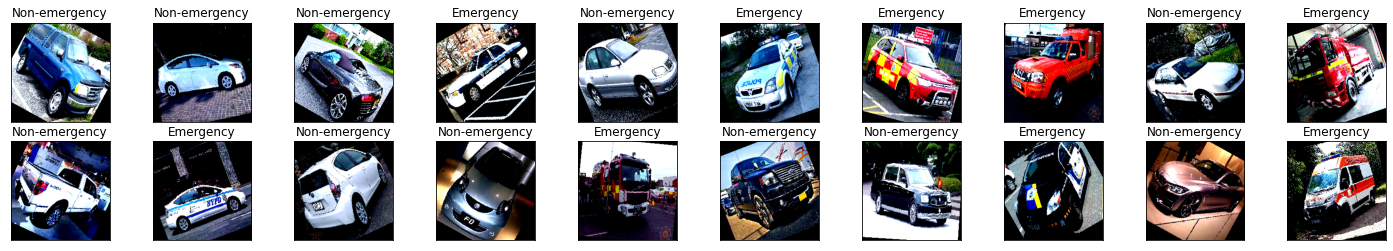

In [4]:
classes = ['Non-emergency', 'Emergency']

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

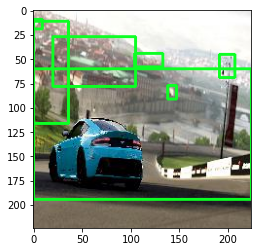

In [5]:
import cv2
import numpy as np

image = cv2.imread(image_dir + "/1466.jpg")
original = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (3, 3), 0)
canny = cv2.Canny(blurred, 120, 255, 1)
kernel = np.ones((5,5),np.uint8)
dilate = cv2.dilate(canny, kernel, iterations=1)

# Find contours
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

# Iterate thorugh contours and filter for ROI
image_number = 0
for i,c in enumerate(cnts):
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
    ROI = original[y:y+h, x:x+w]
    cv2.imwrite("ROI_{}.png".format(image_number), ROI)
    image_number += 1

#Show the image with matplotlib
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

areas of counter 0: 126
areas of counter 1: 30016
areas of counter 2: 384
areas of counter 3: 406
areas of counter 4: 4335
areas of counter 5: 3780
areas of counter 6: 90
largest area is 30016


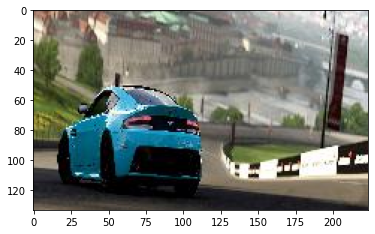

In [6]:
image = cv2.imread(image_dir + "/1466.jpg")
original = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (3, 3), 0)
canny = cv2.Canny(blurred, 120, 255, 1)
kernel = np.ones((5,5),np.uint8)
dilate = cv2.dilate(canny, kernel, iterations=1)

# Find contours
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

# Iterate thorugh contours and find the largest rectangle
area = 0
for i,c in enumerate(cnts):
    _x,_y,_w,_h = cv2.boundingRect(c)
    _area = (_w)*(_h)
    print("areas of counter {}: {}".format(i, _area))
    if _area > area:
        area = _area
        x,y,w,h = _x,_y,_w,_h

print("largest area is {}".format(area))
cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
ROI = original[y:y+h, x:x+w]


#Show the image with matplotlib
image = cv2.cvtColor(ROI, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

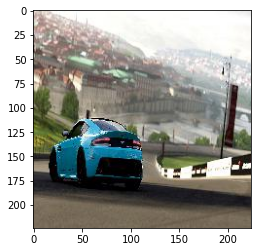

In [7]:
image = cv2.imread(image_dir + "/1466.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [8]:
# downloading the pretrained model
model = models.vgg16(pretrained=True)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print("GPU is available!")
else:
    print("GPU is not available!")

GPU is available!


In [10]:
# freezing the feature extracting layer
for param in model.features.parameters():
    param.requires_grad = False

# modifying the existing last layer of classifier for our use case
model.classifier[6].out_features = len(classes)

# reviewing the changes
print(model.classifier)

if train_on_gpu:
    model = model.cuda()

Linear(in_features=2048, out_features=2, bias=True)


In [0]:
from torch import optim, nn

# specify the loss
criterion = nn.CrossEntropyLoss()

# specify the optimizer
optimizer = optim.SGD(model.fc.parameters(), lr=0.005)

In [12]:
epochs = 20

valid_loss_min = np.Inf

for epoch in range(epochs):
    
    train_loss = 0.
    valid_loss = 0.

    # training the model
    model.train()
    for images, labels in train_loader:
        # sending the tensors to cuda if gpu is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()

        # clearing the accumulated gradients
        optimizer.zero_grad()
        # forward pass
        output = model(images)
        # calculating the batch loss
        loss = criterion(output, labels)
        # back propagation
        loss.backward()
        # updating the weights
        optimizer.step()

        # updatind the training loss
        train_loss += loss.item()*images.size(0)
    
    # evaluating the model
    model.eval()
    for images, labels in valid_loader:
        # sending the tensors to CUDA if GPU is available
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()

        # predicting the outcomes
        output = model(images)
        # calculating the loss
        loss = criterion(output, labels)

        # updating the validation loss
        valid_loss += loss.item()*images.size(0)

    # calculating the average losses
    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)

    # printing the loss for each epoch
    print("Epoch {}: , training loss: {:.6f}, validation loss: {:.6f}".format(epoch+1, 
                                                                      train_loss,
                                                                      valid_loss))
    
    if valid_loss < valid_loss_min:
        print("Validation loss decreased from {:.6f} --> {:.6f}. Saving the model...".
              format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss


Epoch 1: , training loss: 0.911365, validation loss: 0.071925
Validation loss decreased from inf --> 0.071925. Saving the model...
Epoch 2: , training loss: 0.329238, validation loss: 0.056525
Validation loss decreased from 0.071925 --> 0.056525. Saving the model...
Epoch 3: , training loss: 0.286158, validation loss: 0.058034
Epoch 4: , training loss: 0.243603, validation loss: 0.050229
Validation loss decreased from 0.056525 --> 0.050229. Saving the model...
Epoch 5: , training loss: 0.238894, validation loss: 0.048422
Validation loss decreased from 0.050229 --> 0.048422. Saving the model...
Epoch 6: , training loss: 0.218202, validation loss: 0.053729
Epoch 7: , training loss: 0.200278, validation loss: 0.043367
Validation loss decreased from 0.048422 --> 0.043367. Saving the model...
Epoch 8: , training loss: 0.209427, validation loss: 0.043896
Epoch 9: , training loss: 0.196236, validation loss: 0.047246
Epoch 10: , training loss: 0.208663, validation loss: 0.041445
Validation los

In [13]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [0]:
model.eval()
#test_set = next(iter(test_loader))
test_results = []
for images in test_loader:
    # if GPU is available, sending the data to it
    if train_on_gpu:
        images = images.cuda()
    # taking out the predictions
    output = model(images)
    # coverting model probabilities to predicted classes
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
    test_results.extend(preds)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

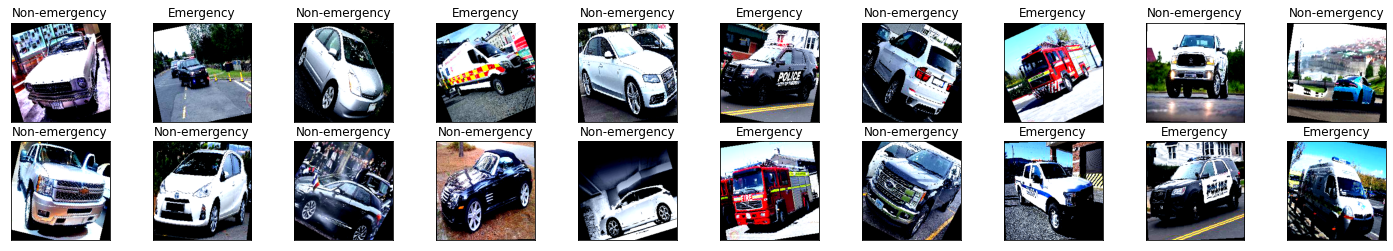

In [15]:
# obtain one batch of test images
dataiter = iter(test_loader)
images = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))

#saving images to CPU to avoid errors
images = images.cpu()

for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{}".format(classes[preds[idx]]))

In [0]:
df = pd.read_csv(test_csv_file)
df["emergency_or_not"] = test_results
df.to_csv("submission.csv", index=False)

In [1]:
!pip install opencv-python

In [2]:
!wget -c https://pjreddie.com/media/files/yolov3.weights

--2020-06-19 19:23:41--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M   438KB/s    in 9m 46s  

2020-06-19 19:33:29 (413 KB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [3]:
!wget -c https://raw.githubusercontent.com/arunponnusamy/object-detection-opencv/master/yolov3.cfg

--2020-06-19 19:33:34--  https://raw.githubusercontent.com/arunponnusamy/object-detection-opencv/master/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2020-06-19 19:33:34 (87.7 MB/s) - ‘yolov3.cfg’ saved [8342/8342]



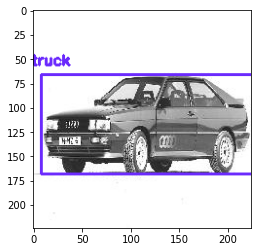